# 1. Setup

In [ ]:
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

In [ ]:
import json

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from pandas import DataFrame, Series, Timedelta, Timestamp
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import DMatrix, XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

# 2. Time Splits

In [ ]:
# train - val - test
# .64 - .16 - .20

In [ ]:
# for i, d in enumerate(test_splits):
#     print(i, "train", d["train"])
#     print(i, "test", d["test"])
#     print(d["train"][1] - d["train"][0])
#     print(d["test"][1] - d["test"][0])

In [ ]:
# N_VAL_SPLITS = 4
# N_TEST_SPLITS = 4
N_SPLITS = 7
FH = 2  # 2d retraining

In [ ]:
train_fix_splits, test_fix_splits = get_split_bounds(
    df["datetime"],
    n_val_splits=N_SPLITS,
    n_test_splits=N_SPLITS,
    fh=FH,
    expanding=False,
)
train_exp_splits, test_exp_splits = get_split_bounds(
    df["datetime"],
    n_val_splits=N_SPLITS,
    n_test_splits=N_SPLITS,
    fh=FH,
    expanding=True,
)

In [ ]:
# for s in [train_fix_splits, test_fix_splits, train_exp_splits, test_exp_splits]:
#     for i, d in enumerate(s):
#         print(i, "train", d["train"])
#         print(i, "test", d["test"])
#         print("train duration", d["train"][1] - d["train"][0])
#         print("test duration", d["test"][1] - d["test"][0])

# 3. Baseline Model

In [ ]:
MODELS_DIR = Path("../models/xgb_baseline")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

ITERS = 1000
VERBOSE = 0
ESR = 50
baseline_params = {
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "eval_metric": "mae",
    "tree_method": "hist",  # GPU
    "device": "cuda",  # GPU
    "n_jobs": -1,
}

In [ ]:
# train_fix_splits
# test_fix_splits
# train_exp_splits
# test_exp_splits

In [ ]:
def drop_split(df: DataFrame, bounds: tuple, to_drop: list):
    start, end = bounds[0], bounds[1]
    subset = df[(df["datetime"] >= start) & (df["datetime"] <= end)].drop(
        to_drop, axis=1
    )
    X, y = subset.drop(["target"], axis=1), subset["target"]
    return X, y

In [ ]:
def load_train_save(
    df: DataFrame,
    split: dict,
    kind: str,
    expanding: bool,
    params: dict,
    to_drop: list,
    models_dir: Path,
    i: int,
    num_boost_round: int = 1000,
    early_stopping_rounds: int = 50,
    verbose_eval: int = 0,
):
    exp_prefix = "fix" if not expanding else "exp"
    model_path = models_dir / f"baseline_{kind}_{exp_prefix}_{i}.ubj" #json
    meta_path = models_dir / f"baseline_{kind}_{exp_prefix}_{i}_meta.json"

    need_to_train = True
    if model_path.exists() and meta_path.exists():
        try:
            with open(meta_path, "r", encoding="utf-8") as fin:
                meta = json.load(fin)
            if (meta.get("train_start") == str(split["train"][0])) and (
                meta.get("train_end") == str(split["train"][1])
            ):
                need_to_train = False
                booster = xgb.Booster()
                booster.load_model(str(model_path))
            else:
                need_to_train = True
        except Exception:
            need_to_train = True

    X_test, y_test = drop_split(df, split["test"], to_drop)
    dtest = DMatrix(X_test, y_test, enable_categorical=True)
    del X_test

    if need_to_train:
        X_train, y_train = drop_split(df, split["train"], to_drop)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        evals = [(dtrain, "train")]
        if kind == "val":
            evals.append((dtest, "val"))

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=verbose_eval,
        )

        booster.save_model( str(model_path))
        meta = {
            "train_start": str(split["train"][0]),
            "train_end": str(split["train"][1]),
            "kind": kind,
            "expanding": str(expanding),
        }
        with open(meta_path, "w", encoding="utf-8") as fout:
            json.dump(meta, fout, ensure_ascii=False, indent=2)

    return booster, dtest, y_test

In [ ]:
baseline_mae = [
    np.empty(len(s))
    for s in [
        train_fix_splits,
        test_fix_splits,
        train_exp_splits,
        test_exp_splits,
    ]
]
baseline_pred = [[]] * 4

splits_list = [
    ("val", False, train_fix_splits),
    ("test", False, test_fix_splits),
    ("val", True, train_exp_splits),
    ("test", True, test_exp_splits),
]
for i_sample, (kind, expanding, splits) in enumerate(splits_list):
    for i, split in enumerate(splits):
        booster, dtest, y_test = load_train_save(
            df,
            split,
            kind,
            expanding,
            baseline_params,
            FEATURES_TO_DROP,
            MODELS_DIR,
            i,
            ITERS,
            ESR,
            VERBOSE,
        )

        preds = booster.predict(dtest)
        baseline_pred[i_sample].append(preds)
        baseline_mae[i_sample][i] = MAE(y_test, preds)

In [ ]:
# [np.mean(k) for s in baseline_mae for k in s]

In [ ]:
# baseline_mae

In [ ]:
mae_df = DataFrame(
    baseline_mae,
    index=[
        "train_fix_splits",
        "test_fix_splits",
        "train_exp_splits",
        "test_exp_splits",
    ],
    columns = [f"{i} split" for i in range(N_SPLITS)],
).T
mae_df = pd.concat([mae_df, mae_df.mean().to_frame("mean").T])
mae_df

,train_fix_splits,test_fix_splits,train_exp_splits,test_exp_splits
0 split,31.49,29.95,31.49,29.91
1 split,45.25,49.84,44.55,52.72
2 split,34.83,54.02,34.02,53.73
3 split,28.38,57.69,29.46,57.25
4 split,29.06,77.82,28.26,81.03
5 split,21.00,59.65,21.33,59.09
6 split,35.28,53.77,34.91,50.50
mean,32.18,54.68,32.00,54.89


# 4. Optuna Search

In [ ]:
N_SPLITS = 3
FH = 2

In [ ]:
optuna_train, optuna_test = get_split_bounds(
    df["datetime"],
    n_val_splits=N_SPLITS,
    n_test_splits=N_SPLITS,
    fh=FH,
    expanding=False,
)

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.001, 100),
        "alpha": trial.suggest_float("alpha", 0.001, 100),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "random_state": RAND,
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)

    cv_predicts = np.empty(len(optuna_train))

    for i, split in enumerate(optuna_train):
        X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        X_val, y_val = drop_split(df, split["test"], FEATURES_TO_DROP)
        dval = DMatrix(X_val, y_val, enable_categorical=True)
        del X_val

        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=evals,
            num_boost_round=num_boost_round,
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        preds = booster.predict(dval)
        cv_predicts[i] = MAE(y_val, preds)

    return np.mean(cv_predicts)

In [ ]:
STORAGE = "sqlite:///../optuna_db/optuna_study_v4.db"
N_TRIALS = 120

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
study = optuna.create_study(
    storage=STORAGE,
    sampler=TPESampler(n_startup_trials=20, multivariate=True),
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="xgb_optuna",
    direction="minimize",
    load_if_exists=True,
)
existing_trials = len(study.trials)

if existing_trials >= N_TRIALS:
    print("Number of existing trials >= N_TRIALS. Skipping optimization.")
else:
    remaining = N_TRIALS - existing_trials
    print(f"Run {remaining} trials to reach {N_TRIALS}")
    study.optimize(
        objective,
        n_trials=remaining,
        show_progress_bar=True,
        n_jobs=1,
    )

/root/.cache/pypoetry/virtualenvs/jlpe-9TtSrW0h-py3.12/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-06 16:50:41,146] Using an existing study with name 'xgb_optuna' instead of creating a new one.


Number of existing trials >= N_TRIALS. Skipping optimization.


In [ ]:
study.best_params
# {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 12}
# 30.988663991292317

# {'learning_rate': 0.1,
# 'max_depth': 10,
# 'min_child_weight': 18,
# 'subsample': 0.8594561164418333,
# 'colsample_bytree': 0.9549790028777667,
# 'lambda': 80.67437718316565,
# 'alpha': 8.579982090257277,
# 'num_boost_round': 1500}
# 30.306320826212566


# {'learning_rate': 0.10842258169357744,
#  'max_depth': 10,
#  'min_child_weight': 9,
#  'subsample': 0.968120281133485,
#  'colsample_bytree': 0.9514698765601128,
#  'lambda': 56.77594835612019,
#  'alpha': 36.40618084787037,
#  'num_boost_round': 1000}
# 30.03012466430664

{'learning_rate': 0.12955909819009542,
 'max_depth': 8,
 'min_child_weight': 15,
 'subsample': 0.8065646133039029,
 'colsample_bytree': 0.6830256079490086,
 'lambda': 3.016122254933946,
 'alpha': 2.3138452407643086,
 'gamma': 4.8453125877357195,
 'grow_policy': 'depthwise',
 'num_boost_round': 2000}

In [ ]:
def detailed_objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.001, 100),
        "alpha": trial.suggest_float("alpha", 0.001, 100),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "random_state": RAND,
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)

    cv_predicts = np.empty(len(optuna_test))

    for i, split in enumerate(optuna_test):
        X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        X_val, y_val = drop_split(df, split["test"], FEATURES_TO_DROP)
        dval = DMatrix(X_val, y_val, enable_categorical=True)
        del X_val

        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=evals,
            num_boost_round=num_boost_round,
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        preds = booster.predict(dval)
        cv_predicts[i] = MAE(y_val, preds)

    # return np.mean(cv_predicts)
    return cv_predicts

In [ ]:
test = detailed_objective(study.best_trial)

In [ ]:
np.mean(test)

np.float64(49.72040685017904)

In [ ]:
study.best_value

30.789238611857098

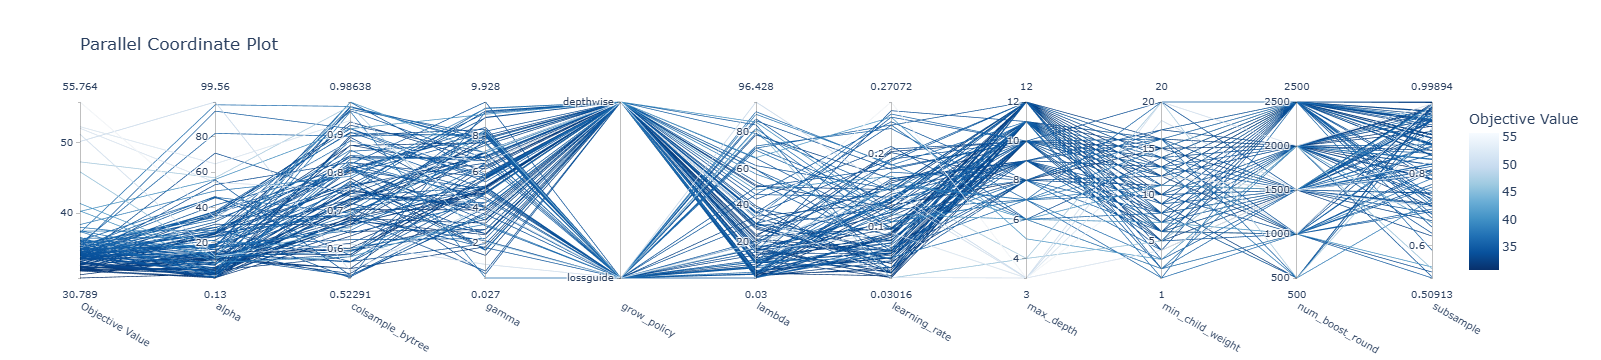

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

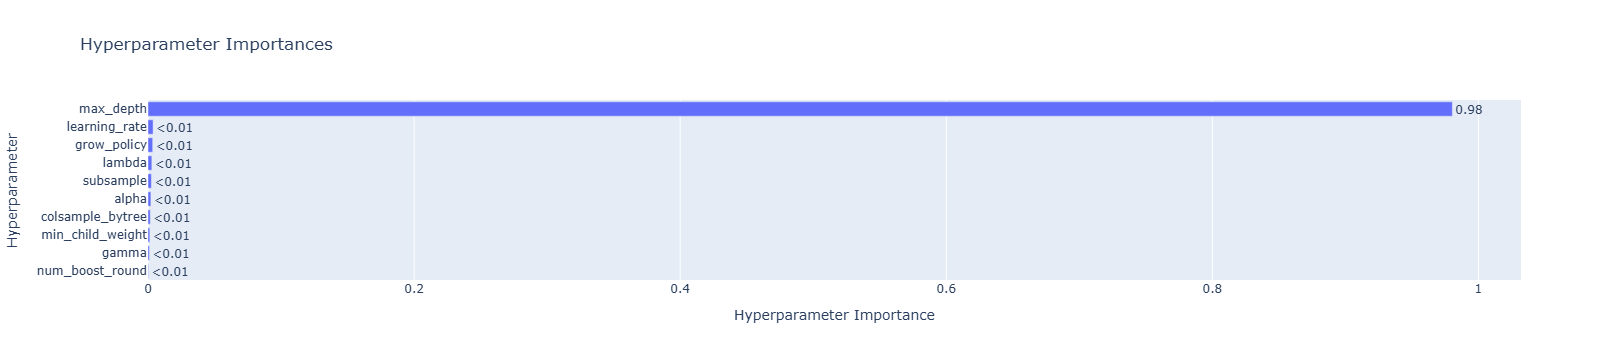

In [ ]:
optuna.visualization.plot_param_importances(study)

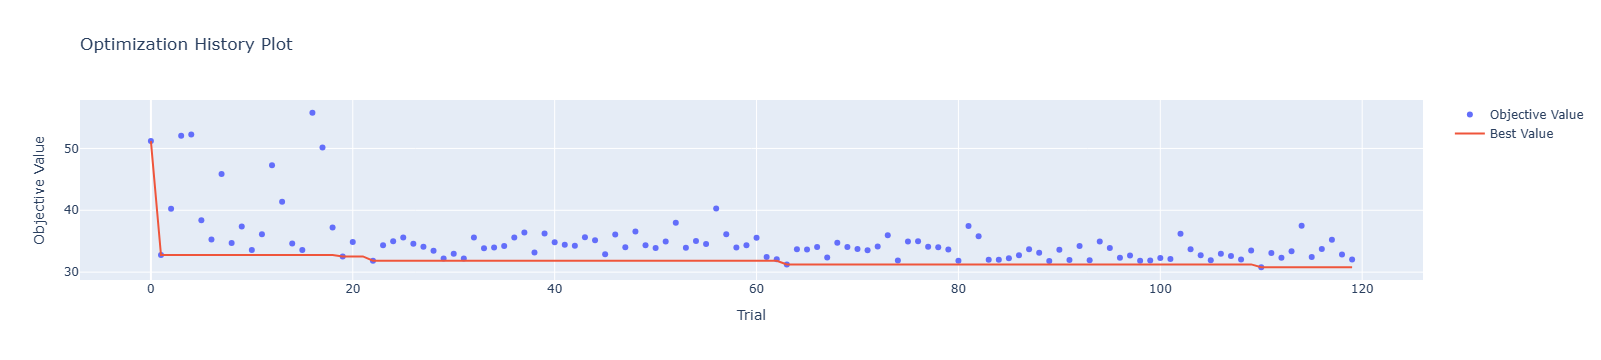

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_contour(study)

In [ ]:
# for split in [[xgb_mae_history[i]["validation_1"]["mae"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# for split in [[lgbm_mae_history[i]["valid_1"]["l1"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# for split in [[cb_mae_history[i]["validation_1"]["MAE"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# [[i for i in range(split * 5, split * 5 + 5)] for split in range(4)]

# residuals = y_test - y_pred

# plt.scatter(y_pred, residuals, alpha=0.5)
# plt.axhline(0, color="red", linestyle="--")
# plt.xlabel("Predicted")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Predicted")
# plt.show()

# fi = pd.Series(xgbr.feature_importances_, index=X_train.columns)
# fi = fi.sort_values(ascending=False).head(20)

# fi.plot.barh(figsize=(8,6))
# plt.xlabel("Feature Importance")
# plt.gca().invert_yaxis()
# plt.title("Top 20 Important Features")
# plt.show()